# Demand Forecasting (Pipeline & Modeling)

the objective of the model is to forecast the amount of qty_total for every item that should be available for the next week.


input:
- date: datetime --> predict on date
- B1G1: Bool --> Will there be a B1G1 promo?
- FS: Bool --> Will there be a FS promo
- menu_group: String  --> predicted menu

output:
- qty_1w: amount of qty should be availble for that week

In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error

from bayes_opt import BayesianOptimization

## Load Data

In [59]:
FOLDER_PATH = '/Users/louisn/Documents/Legit-DS/Selection/demand-forecasting/data/'
DATA_PATH = FOLDER_PATH + 'interview-test.csv'

In [60]:
df = pd.read_csv(DATA_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8902 entries, 0 to 8901
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   salesdate   8902 non-null   object
 1   menuid      8902 non-null   int64 
 2   menuname    8902 non-null   object
 3   package     8902 non-null   object
 4   salesNum    8902 non-null   int64 
 5   bomid       8902 non-null   int64 
 6   menu_group  8902 non-null   object
 7   qty_total   8902 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 556.5+ KB


## Preprocessing

In [61]:
df['salesdate'] = pd.to_datetime(df['salesdate'], format='%Y-%m-%d')
df.set_index('salesdate', inplace=True)

In [62]:
df.sample(1)

,menuid,menuname,package,salesNum,bomid,menu_group,qty_total
salesdate,,,,,,,
2023-03-08,540,Gyudon Aburi with Miso Mayo & Sambal Korek,Package Content,4795,88,Gyudon Aburi with Miso Mayo & Sambal Korek,1


In [63]:
# split train & test data
split_dt = "2023-02-28"

train = df.loc[:split_dt]
test = df.loc[split_dt:]
ratio = len(test) / (len(train)+len(test))

print(f"train : {len(train)}")
print(f"test : {len(test)}")
print(f"test ratio: {ratio}.2f")

train : 6881
test : 2221
test ratio: 0.24401230498791474.2f


In [162]:
def preprocess_input(df):
    df = df[df['menu_group'] != '0'].copy()
    # datetime preprocessing
    try:
        df['salesdate'] = pd.to_datetime(df['salesdate'], format='%Y-%m-%d')
    except:
        pass

    # check for FS and B1G1 Promos
    patternFs = r'\[(.*?)\]'
    df['FS'] = df['menuname'].str.contains(patternFs)

    # extract pattern B1G1
    patternB1g1 = r'(B1G1)'
    df['B1G1'] = df['menuname'].str.contains(patternB1g1)

    # drop unrelevant cols
    df.drop(columns=['menuid','package','menuname','salesNum','bomid'], axis=1, inplace=True)

    # pivot on weekdays
    df_weekly = df.resample('W').sum()
    df_weekly.rename(columns= {
        'FS': 'FS_total',
        'B1G1': 'B1G1_total'
    }, inplace=True)

    # feature engineerid week of month
    # df_weekly['day'] = df_weekly.index.weekday
    df_weekly['week'] = (df_weekly.index.day - 1) // 7 + 1
    df_new = pd.get_dummies(df_weekly, columns=['week'])

    # split X and Y
    y = df_new['qty_total'].copy()
    X = df_new.drop('qty_total', axis=1).copy()

    return df_new, X, y

In [163]:
df_preprocessed, X, y = preprocess_input(df)
df_preprocessed.head(10) 

/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/2396545609.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['FS'] = df['menuname'].str.contains(patternFs)
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/2396545609.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['B1G1'] = df['menuname'].str.contains(patternB1g1)
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/2396545609.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_weekly = df.resample('W').sum()


,qty_total,FS_total,B1G1_total,week_1,week_2,week_3,week_4,week_5
salesdate,,,,,,,,
2022-05-22,80,0,0,0,0,0,1,0
2022-05-29,151,0,0,0,0,0,0,1
2022-06-05,77,0,0,1,0,0,0,0
2022-06-12,90,2,0,0,1,0,0,0
2022-06-19,29,4,0,0,0,1,0,0
2022-06-26,0,0,0,0,0,0,1,0
2022-07-03,34,0,0,1,0,0,0,0
2022-07-10,113,0,0,0,1,0,0,0
2022-07-17,92,0,0,0,0,1,0,0


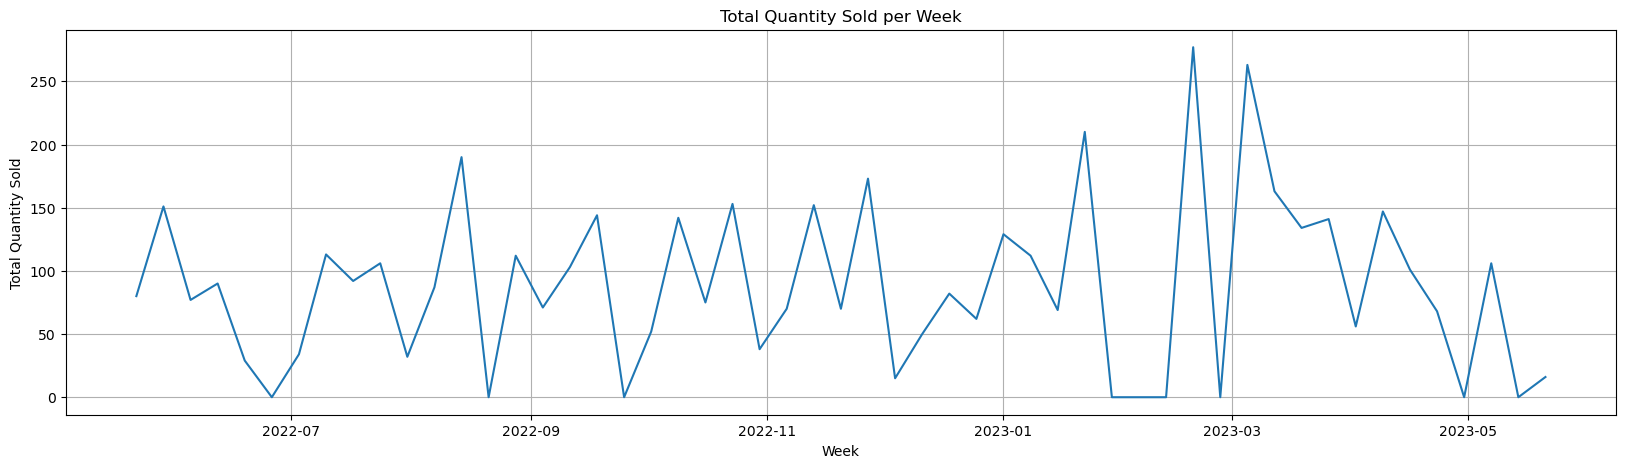

In [164]:
# Plot Graph
plt.figure(figsize=(20,5))
plt.plot(df_preprocessed.index, df_preprocessed['qty_total'])
plt.title('Total Quantity Sold per Week')
plt.xlabel('Week')
plt.ylabel('Total Quantity Sold')
plt.grid(True)
plt.show()

**Caution!: We could see that there are a seasonality pattern until 2023-01. This maybe caused because the sales haven't reached it's "stable state", so the model might be useful if there are already more data that exhibit seasonability, but until then we shall predict by using the train and test data that splitted on "2023-02-28"**

In [165]:
trainDf, trainX, trainY = preprocess_input(train)
testDf, testX, testY = preprocess_input(test)

print(f"trainX: {trainX.shape} | trainY: {trainY.shape}")
print(f"testX : {testX.shape} | testY : {testY.shape}")

trainX: (42, 7) | trainY: (42,)
testX : (12, 7) | testY : (12,)


/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/2396545609.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['FS'] = df['menuname'].str.contains(patternFs)
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/2396545609.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['B1G1'] = df['menuname'].str.contains(patternB1g1)
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/2396545609.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_weekly = df.resample('W').sum()
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/2396545609.py:11: UserWarning: This pat

In [166]:
# Scaling model to be passed to modeling 
scaler = MinMaxScaler()

trainX_scaled = scaler.fit_transform(trainX)
testX_scaled = scaler.transform(testX)

## Modeling

### XGBoost (MAE: 64.14447275797527)

XGBoost could be usable because it's capability to do multivariate forecasting and it's commmonly known for its effectiveness.

In [167]:
import xgboost as xgb

In [206]:
# Convert data into DMatrix format for XGBoost Multivariate
dTrain = xgb.DMatrix(data=trainX, label=trainY)
dTest =xgb.DMatrix(data=testX)

# XGBoost Parameter
params = {
    'objective': 'reg:squarederror',
    'eta': 0.1,
    'max_depth': 3,
    'learning_rate': 0.1,
}

# train 
model = xgb.train(params, dTrain)

# predict
yPred = model.predict(dTest)

# evaluate
mae = mean_absolute_error(testY, yPred)

print(f"MAE: {np.mean(mae)}")

MAE: 64.14447275797527


In [207]:
eval = testY.to_frame()
eval['pred'] = yPred
eval.head(12)

,qty_total,pred
salesdate,,
2023-03-05,148,40.547638
2023-03-12,163,49.775406
2023-03-19,134,44.751770
2023-03-26,141,38.347595
2023-04-02,56,30.499279
2023-04-09,147,49.775406
2023-04-16,101,35.523994
2023-04-23,68,38.347595
2023-04-30,0,33.025921


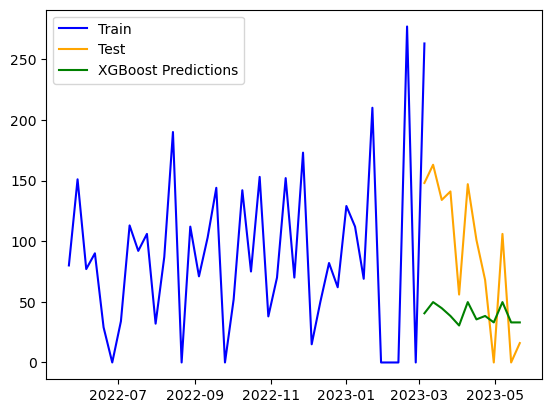

In [208]:
# plot 
plt.plot(trainY, color='blue', label = 'Train')
plt.plot(eval['qty_total'], color='orange', label = 'Test')
plt.plot(eval['pred'], color='green', label = 'XGBoost Predictions')
plt.legend()

#### Tuning

In [223]:
def black_box_XGBoost(eta, max_depth, learning_rate):
    # input params
    params = {
        'objective': 'reg:squarederror',
        'eta': eta,
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
    }

    # train 
    model = xgb.train(params, dTrain)

    # predict
    yPred = model.predict(dTest)

    # evaluate
    mae = mean_absolute_error(testY, yPred)

    return -mae

In [224]:
param_bounds = {
    'eta': (0.01, 0.3),
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.1),
}

optimizer = BayesianOptimization(
    f=black_box_XGBoost,
    pbounds=param_bounds,
    random_state=1,
)

In [226]:
optimizer.maximize(
    init_points=3, 
    n_iter=100, 
)

|   iter    |  target   |    eta    | learni... | max_depth |
-------------------------------------------------------------
| 54        | -73.28    | 0.1663    | 0.04773   | 7.797     |
| 55        | -65.83    | 0.06929   | 0.08903   | 3.192     |
| 56        | -73.32    | 0.2044    | 0.04756   | 6.911     |
| 57        | -64.79    | 0.01032   | 0.09645   | 4.01      |
| 58        | -68.97    | 0.02224   | 0.06919   | 9.938     |
| 59        | -64.25    | 0.02985   | 0.1       | 4.12      |
| 60        | -66.4     | 0.04151   | 0.08339   | 9.822     |
| 61        | -79.49    | 0.2628    | 0.02607   | 5.932     |
| 62        | -80.45    | 0.03085   | 0.02405   | 7.742     |
| 63        | -64.25    | 0.119     | 0.1       | 4.209     |
| 64        | -66.17    | 0.01802   | 0.08335   | 4.288     |
| 65        | -64.34    | 0.2966    | 0.09866   | 3.971     |
| 66        | -64.39    | 0.2767    | 0.09908   | 4.176     |
| 67        | -82.36    | 0.2612    | 0.0186    | 4.244     |
| 68    

In [228]:
best_hyperparameters = optimizer.max['params']
best_hyperparameters

{'eta': 0.01, 'learning_rate': 0.1, 'max_depth': 3.2832530005659883}

MAE: 64.14447275797527


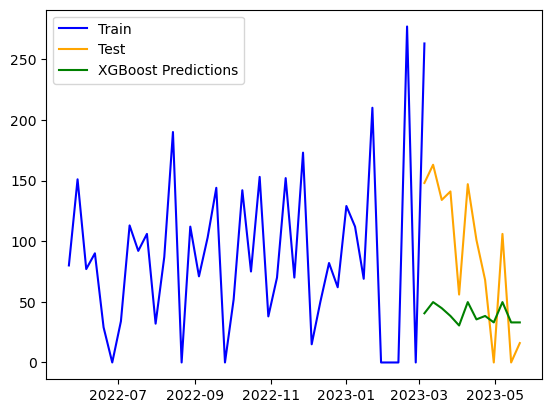

In [229]:
# XGBoost Parameter
params = {
    'objective': 'reg:squarederror',
    'eta': 0.01,
    'max_depth': 3,
    'learning_rate': 0.1,
}

# train 
model = xgb.train(params, dTrain)

# predict
yPred = model.predict(dTest)

# evaluate
mae = mean_absolute_error(testY, yPred)

print(f"MAE: {np.mean(mae)}")

eval = testY.to_frame()
eval['pred'] = yPred
eval.head(12)

# plot 
plt.plot(trainY, color='blue', label = 'Train')
plt.plot(eval['qty_total'], color='orange', label = 'Test')
plt.plot(eval['pred'], color='green', label = 'XGBoost Predictions')
plt.legend()

### VARMA (still error)

VARMA is suitable for multiple variables that may have dependencies on each other. VARMA extends the concepts of ARIMA to multiple variable

In [236]:
trainDf.head()

,qty_total,FS_total,B1G1_total,week_1,week_2,week_3,week_4,week_5
salesdate,,,,,,,,
2022-05-22,80,0,0,0,0,0,1,0
2022-05-29,151,0,0,0,0,0,0,1
2022-06-05,77,0,0,1,0,0,0,0
2022-06-12,90,2,0,0,1,0,0,0
2022-06-19,29,4,0,0,0,1,0,0


In [239]:
# # VARMA params
# params = {
#     'p': 2,
#     'q': 1
# }

# # train
# model = sm.tsa.VARMAX(trainX_scaled, order=(params['p'], params['q']))
# results = model.fit()

# # predict
# forecast = results.forecast(steps=len(testY))

### VAR

In [240]:
from statsmodels.tsa.vector_ar.var_model import VAR

In [254]:
dfTrain_new = trainDf.rename({'qty_total':'y'}, axis=1)
dfTrain_new.head()

,y,FS_total,B1G1_total,week_1,week_2,week_3,week_4,week_5
salesdate,,,,,,,,
2022-05-22,80,0,0,0,0,0,1,0
2022-05-29,151,0,0,0,0,0,0,1
2022-06-05,77,0,0,1,0,0,0,0
2022-06-12,90,2,0,0,1,0,0,0
2022-06-19,29,4,0,0,0,1,0,0


In [270]:
# Params 


# VAR model
model = VAR(dfTrain_new)
model_fit = model.fit()

# lag order
lag_order = model_fit.k_ar
print("Lag order selected:", lag_order)

# predict
n_steps = len(testY)
forecast = model_fit.forecast(model_fit.endog, steps=n_steps)
pred = forecast[:, 0]

# evaluate
mae = mean_absolute_error(testY, pred)

print(f"MAE: {np.mean(mae)}")

Lag order selected: 1
MAE: 53.27782044222575


In [272]:
eval = testY.to_frame()
eval['pred'] = pred
eval.head(12)

,qty_total,pred
salesdate,,
2023-03-05,148,8.108588
2023-03-12,163,129.699137
2023-03-19,134,79.419376
2023-03-26,141,83.086112
2023-04-02,56,75.866362
2023-04-09,147,100.532972
2023-04-16,101,88.688588
2023-04-23,68,87.568224
2023-04-30,0,75.998909


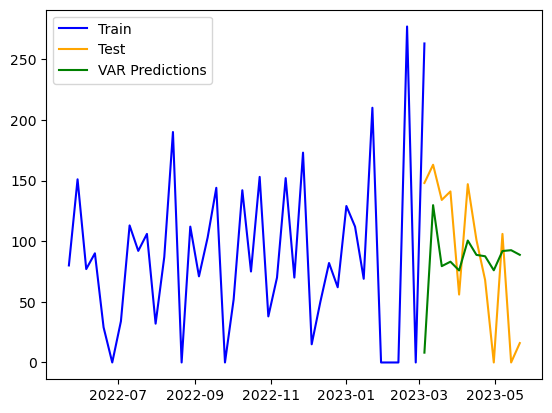

In [274]:
# plot 
plt.plot(trainY, color='blue', label = 'Train')
plt.plot(eval['qty_total'], color='orange', label = 'Test')
plt.plot(eval['pred'], color='green', label = 'VAR Predictions')
plt.legend()